# Stable Diffusion 1.5: LoRA finetuning on Midjourney images

Fine-tuning on a dataset of images generated by Midjourney ([reference](https://huggingface.co/datasets/MohamedRashad/midjourney-detailed-prompts)). [Command R](https://huggingface.co/CohereForAI/c4ai-command-r-v01) is used to generate the short prompts used during training.

For the images only a subset of the original dataset are used. All of the square images (height=width) with 512px and more. All images are resized to 512px for training ([dataset resized](https://www.kaggle.com/datasets/ostamand/midjourney-v0)).

For simple comparison, two images are generated with and without the LoRA weights being applied.

The implementation of the LoRA finetuning is meant to be as simple as possible, keeping only what is needed to run on a single GPU having >12Gb VRAM.

In [ ]:
!git clone https://<Github Token>@github.com/chaima-gabtni11/PI_Project.git

Cloning into 'PI_Project'...
remote: Enumerating objects: 937, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 937 (delta 0), reused 1 (delta 0), pack-reused 934 (from 2)
Receiving objects: 100% (937/937), 53.36 MiB | 18.62 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [ ]:

import pandas as pd
import os
from PIL import Image

# Update paths according to where Kaggle mounts your files
image_dir = "/kaggle/input/your-image-folder/images"  # replace with actual folder name
csv_path = "/kaggle/input/your-caption-csv/statue_descriptions.csv"  # replace with actual CSV file

df = pd.read_csv(csv_path)
df['image_path'] = df['image'].apply(lambda x: os.path.join(image_dir, x))
df['short_prompt'] = df['description']  # if needed for consistency with previous naming
df.head()


In [ ]:

from datasets import Dataset
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

def load_sample(example):
    image = Image.open(example["image_path"]).convert("RGB")
    example["pixel_values"] = transform(image)
    return example

dataset = Dataset.from_pandas(df[["image_path", "short_prompt"]])
dataset = dataset.map(load_sample)


In [2]:
import os
import pandas as pd

# Define paths to your folders
images_folder = "/kaggle/working/PI_Project/data_diffusion/data_prep/images"
descriptions_folder = "/kaggle/working/PI_Project/data_diffusion/data_prep/descriptions"  # assuming text files are in the root directory

# Get list of image files
image_files = [f for f in os.listdir(images_folder) if f.endswith(('.jpg', '.png'))]

# Get list of text files
text_files = [f for f in os.listdir(descriptions_folder) if f.endswith('.txt')]

# Create a dictionary to store image-description pairs
data = []

# For each image file, find corresponding text file and read description
for img_file in image_files:
    # Get the base name without extension
    img_base_name = os.path.splitext(img_file)[0]
    
    # Look for matching text file
    txt_file = f"{img_base_name}.txt"
    
    if txt_file in text_files:
        # Read the description from the text file
        with open(os.path.join(descriptions_folder, txt_file), 'r') as f:
            description = f.read().strip()
        
        # Add to our data
        data.append({
            "image": os.path.join(images_folder, img_file),
            "short_prompt": description
        })

# Create a DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

# Optionally save to CSV
df.to_csv("image_descriptions.csv", index=False)

                                                 image  \
0    /kaggle/working/PI_Project/data_diffusion/data...   
1    /kaggle/working/PI_Project/data_diffusion/data...   
2    /kaggle/working/PI_Project/data_diffusion/data...   
3    /kaggle/working/PI_Project/data_diffusion/data...   
4    /kaggle/working/PI_Project/data_diffusion/data...   
..                                                 ...   
299  /kaggle/working/PI_Project/data_diffusion/data...   
300  /kaggle/working/PI_Project/data_diffusion/data...   
301  /kaggle/working/PI_Project/data_diffusion/data...   
302  /kaggle/working/PI_Project/data_diffusion/data...   
303  /kaggle/working/PI_Project/data_diffusion/data...   

                                          short_prompt  
0    This image depicts a bas-relief sculpture from...  
1    This image depicts a statue, likely from the N...  
2    This painting, titled 'The Course of Empire: D...  
3    This image depicts a Lamassu, a protective dei...  
4    This image de

In [3]:
from PIL import Image
import numpy as np
image = Image.open(df["image"].iloc[0]).convert("RGB")
np.asarray(image).shape

(1024, 1024, 3)

In [4]:
"""!pip install diffusers
!pip install peft"""

'!pip install diffusers\n!pip install peft'

In [5]:
from pathlib import Path
from diffusers import UNet2DConditionModel, AutoencoderKL, DDPMScheduler, StableDiffusionPipeline, DiffusionPipeline
from transformers import CLIPTextModel, CLIPTokenizer
from huggingface_hub import login
from peft import LoraConfig
import torch
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from peft.utils import get_peft_model_state_dict
from diffusers.utils import convert_state_dict_to_diffusers
from datasets import load_dataset
from functools import partial
from PIL import Image
from kaggle_secrets import UserSecretsClient
from torch.utils.data import Dataset
import pandas as pd
from pydantic import BaseModel
from diffusers.training_utils import compute_snr

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [6]:
#login(token=UserSecretsClient().get_secret("HF_TOKEN"))

BackendError: Unexpected response from the service. Response: {'errors': ['No user secrets exist for kernel id 80315114 and label HF_TOKEN.'], 'error': {'code': 5, 'details': []}, 'wasSuccessful': False}.

In [7]:
def get_models(model_name, dtype=torch.float16):
    tokenizer = CLIPTokenizer.from_pretrained(model_name, subfolder="tokenizer")
    text_encoder = CLIPTextModel.from_pretrained(model_name, subfolder="text_encoder").to(dtype=dtype)
    vae = AutoencoderKL.from_pretrained(model_name, subfolder="vae").to(dtype=dtype)
    scheduler = DDPMScheduler.from_pretrained(model_name, subfolder="scheduler")
    unet = UNet2DConditionModel.from_pretrained(model_name, subfolder="unet").to(dtype=dtype)
    return tokenizer, text_encoder, vae, scheduler, unet

In [13]:
class MidjourneyDataset(Dataset):
    def __init__(self, data_dir: Path, tokenizer: CLIPTokenizer):
        self.data_dir = data_dir
        self.df = pd.read_csv("/kaggle/working/image_descriptions.csv" )#data_dir / "index.csv")
        self.tokenizer = tokenizer
        
        self.train_tranforms = transforms.Compose(
            [
                transforms.Resize((256*2, 256*2)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df.iloc[idx]["image"]#self.data_dir / "images" / self.df.iloc[idx]["image"]
        image = Image.open(image_path).convert("RGB")
        image = self.train_tranforms(image)

        input_ids = self.tokenizer(
            self.df.iloc[idx]["short_prompt"],
            max_length=self.tokenizer.model_max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )["input_ids"][0]

        return {"pixel_values": image, "input_ids": input_ids}

In [9]:
def setup_models_for_training(model_name, rank: int=128):
    tokenizer, text_encoder, vae, scheduler, unet = get_models(model_name)

    # freeze all weights
    for m in (unet, text_encoder, vae):
        for p in m.parameters():
            p.requires_grad = False

    # config LoRA
    unet_lora_config = LoraConfig(
        r=rank,
        lora_alpha=rank,
        init_lora_weights="gaussian",
        target_modules=["to_k", "to_q", "to_v", "to_out.0"],
    )

    unet.add_adapter(unet_lora_config)

    # set trainaible weights to float32
    for p in unet.parameters():
        if p.requires_grad:
            p.data = p.to(dtype=torch.float32)

    return tokenizer, text_encoder, vae, scheduler, unet

def get_lora_params(unet):
    return [p for p in filter(lambda p: p.requires_grad, [p for p in unet.parameters()])]

In [10]:
class TrainingConfig(BaseModel):
    train_steps: int = 100
    lr: float = 1e-5
    batch_size: int = 4
    accumulation_steps: int = 2
    rank: int = 128
    max_grad_norm: float = 1.0
    pretrained_name: str = "runwayml/stable-diffusion-v1-5"
    data_dir: str = "/kaggle/input/midjourney-v0/midjourney-512px-v0"
    snr_gamma: float = -1
    seed: int = -1

In [11]:
def train(
    tokenizer: CLIPTokenizer, 
    text_encoder: CLIPTextModel, 
    vae: AutoencoderKL, 
    scheduler: DDPMScheduler, 
    unet: UNet2DConditionModel,
    config: TrainingConfig,
    device = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    lora_params = get_lora_params(unet)

    text_encoder.to(device).eval()
    vae.to(device).eval()
    unet.to(device).train()

    # data set
    train_dataset = MidjourneyDataset(Path(config.data_dir), tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)

    # optimizer
    steps_per_epoch = math.ceil(len(train_dataloader) / config.accumulation_steps)
    epochs = math.ceil(config.train_steps / steps_per_epoch)

    lr = config.lr * config.accumulation_steps * config.batch_size
    optimizer = torch.optim.AdamW(lora_params, lr=lr)

    scaler = torch.cuda.amp.GradScaler()

    # progress bar setup
    global_step = 0
    progress_bar = tqdm(
        range(config.train_steps),
        desc="Steps"
    )

    print(f"configs: {config}")
    print(f"epochs: {epochs}")
    print(f"steps per epoch: {steps_per_epoch}")
    print(f"total steps: {config.train_steps}")
    print(f"accumulation steps: {config.accumulation_steps}")
    print(f"total batch size: {config.batch_size * config.accumulation_steps}")
    print(f"lr: {lr}")

    losses = []
    for _ in range(epochs):
        for step, batch in enumerate(train_dataloader):
            bs = batch["input_ids"].shape[0]

            with torch.autocast(device_type="cuda", dtype=torch.float16):
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"].to(device), return_dict=False)[0]

                timesteps = torch.randint(0, scheduler.config.num_train_timesteps, (bs,)).long().to(device)

                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"].to(device)).latent_dist.sample()
                    latents = latents * vae.config.scaling_factor

                noise = torch.randn_like(latents)
                noisy_latents = scheduler.add_noise(latents, noise, timesteps)
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states, return_dict=False)[0]

                if config.snr_gamma > 0:
                    # should converge faster with snr_gamma, however works well with unweighted mse
                    # https://arxiv.org/abs/2303.09556
                    # https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py
                    snr = compute_snr(scheduler, timesteps)
                    mse_loss_weights = torch.stack([snr, config.snr_gamma * torch.ones_like(timesteps)], dim=1).min(
                        dim=1
                    )[0]
                    mse_loss_weights = mse_loss_weights / snr
                    loss = F.mse_loss(noise_pred, noise, reduction="none")
                    loss = loss.mean(dim=list(range(1, len(loss.shape)))) * mse_loss_weights
                    loss = loss.mean()
                else:
                    loss = F.mse_loss(noise_pred, noise, reduction="mean")

            global_step+=1
            scaler.scale(loss).backward()

            if global_step % config.accumulation_steps == 0:
                if config.max_grad_norm > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(lora_params, config.max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                progress_bar.update(1)

            losses.append(loss.item())

            progress_bar.set_postfix({"loss": losses[-1]})
            if global_step / config.accumulation_steps >= config.train_steps:
                break
    
    return {
        "losses": losses
    }

In [14]:
try:
    # in case of rerun, to make sure we free up GPU before calling train
    del models, pipe
    import gc; gc.collect()
    torch.cuda.empty_cache()
except:
    pass

config = TrainingConfig()
config.lr = 1e-5
config.rank = 62
config.train_steps = 100#0
config.snr_gamma = 5.0
config.seed = 42

torch.manual_seed(config.seed)

models = setup_models_for_training(config.pretrained_name, rank=config.rank)

outputs = train(
    *models,
    config,
)

<ipython-input-11-17843f4ee72f>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Steps:   0%|          | 0/1000 [00:00<?, ?it/s]

configs: train_steps=1000 lr=1e-05 batch_size=4 accumulation_steps=2 rank=62 max_grad_norm=1.0 pretrained_name='runwayml/stable-diffusion-v1-5' data_dir='/kaggle/input/midjourney-v0/midjourney-512px-v0' snr_gamma=5.0 seed=42
epochs: 27
steps per epoch: 38
total steps: 1000
accumulation steps: 2
total batch size: 8
lr: 8e-05


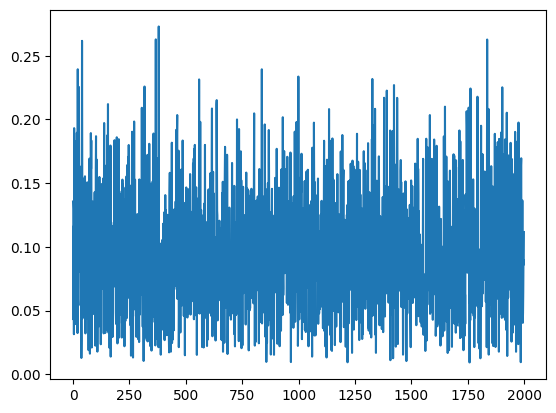

In [15]:
plt.plot(outputs["losses"])
plt.show()

Save LoRA weights

In [16]:
unet = models[-1]
unet_lora_state_dict = convert_state_dict_to_diffusers(get_peft_model_state_dict(unet))

In [17]:
StableDiffusionPipeline.save_lora_weights(
    save_directory="./out",
    unet_lora_layers=unet_lora_state_dict,
    safe_serialization=True,
)

In [18]:
!ls -l -h ./out/pytorch_lora_weights.safetensors

-rw-r--r-- 1 root root 48M Apr  7 01:01 ./out/pytorch_lora_weights.safetensors


Compare inference with and without LoRA weights applied.

We will generate two images per model. One from a taken from the training data (a robot with an unbrella) and one new. 

In [19]:
df = pd.read_csv("/kaggle/working/image_descriptions.csv") #Path(config.data_dir) / "index.csv")

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

prompt_training = [df.iloc[0]["short_prompt"]]
prompt_new = "Hannibal Carthaginian general"
num_inference_steps=35
seed = 3

In [21]:
def generate(pipeline, prompt, seed):
    generator = torch.Generator(device=device).manual_seed(seed)
    return pipeline(prompt, num_inference_steps=num_inference_steps, generator=generator).images[0]

In [22]:
pipe = DiffusionPipeline.from_pretrained(
    config.pretrained_name,
    torch_dtype=torch.float16
).to(device)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Display image take from training data for reference

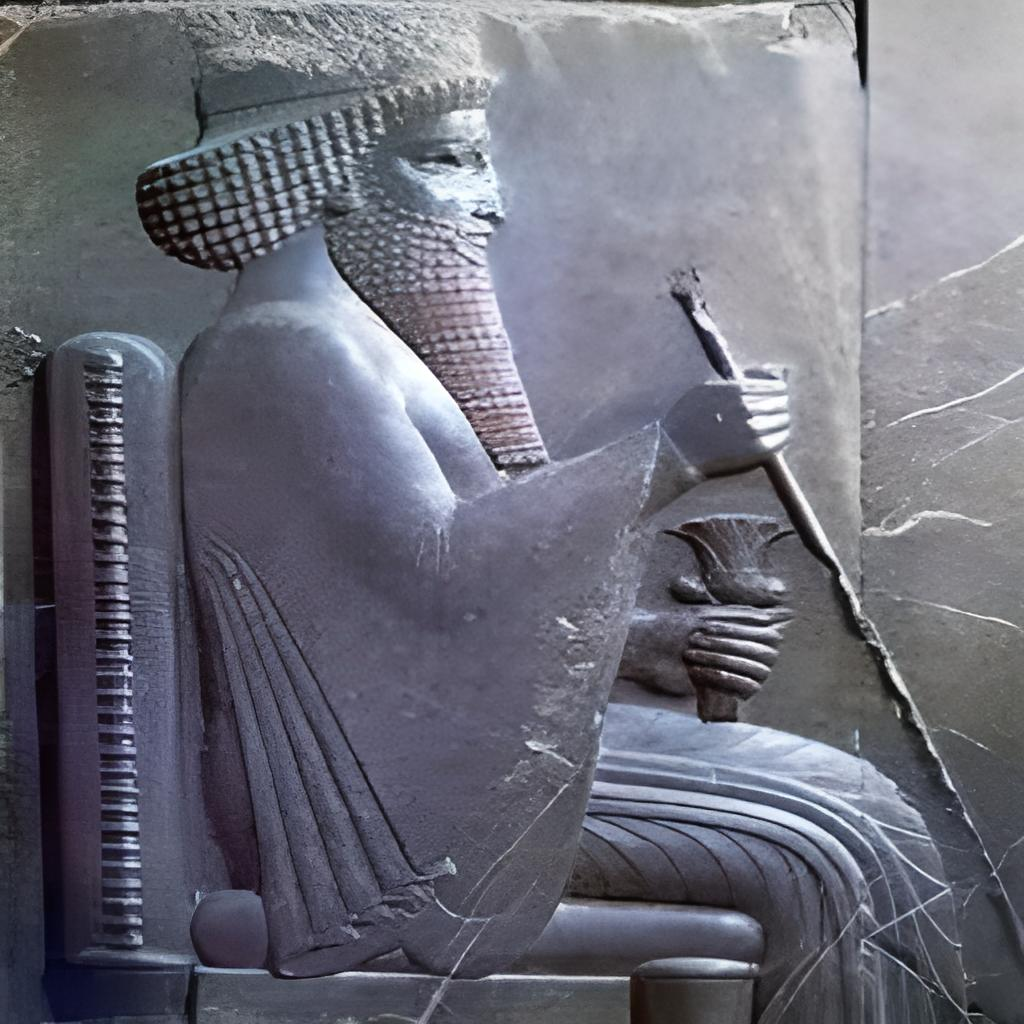

In [23]:
Image.open(df.iloc[0]["image"])#Path(config.data_dir) / "images" / df.iloc[0]["image"])

Generate images from pretrained model. First the training image, then the new prompt

Token indices sequence length is longer than the specified maximum sequence length for this model (158 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["assyrian rulers . the culture represented is mesopotamian , specifically assyrian , and the figure likely represents ashurnasirpal ii himself , showcasing the stylized beards and intricate details characteristic of assyrian sculpture . the seated pose and ceremonial objects suggest a scene of royal authority or religious significance . these reliefs served as narrative devices , visually reinforcing the king 's authority and historical accounts of his reign ."]


  0%|          | 0/35 [00:00<?, ?it/s]

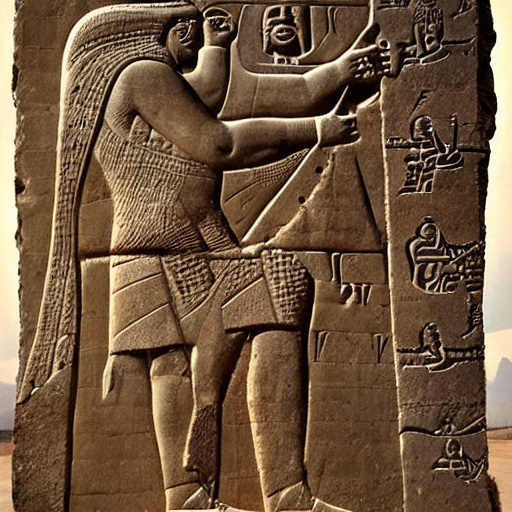

In [24]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

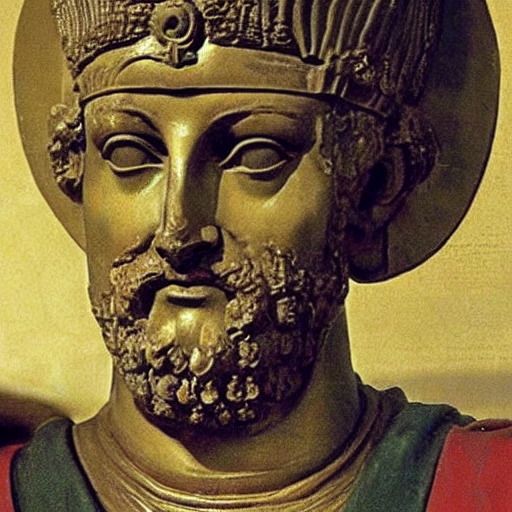

In [25]:
generate(pipe, prompt_new, seed)

Apply the LoRA weights and run the same two prompts.

In [26]:
pipe.load_lora_weights("./out/pytorch_lora_weights.safetensors")

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ["assyrian rulers . the culture represented is mesopotamian , specifically assyrian , and the figure likely represents ashurnasirpal ii himself , showcasing the stylized beards and intricate details characteristic of assyrian sculpture . the seated pose and ceremonial objects suggest a scene of royal authority or religious significance . these reliefs served as narrative devices , visually reinforcing the king 's authority and historical accounts of his reign ."]


  0%|          | 0/35 [00:00<?, ?it/s]

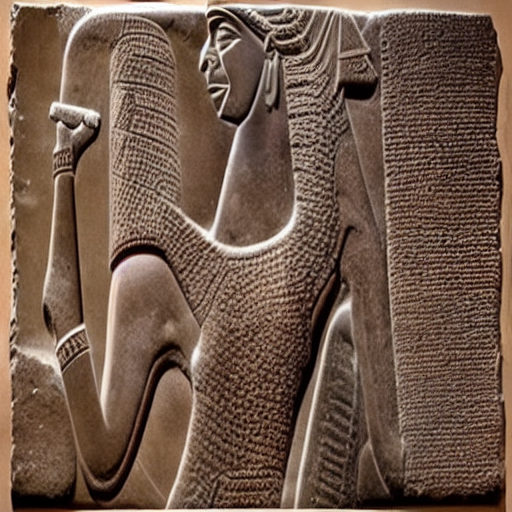

In [27]:
generate(pipe, prompt_training, seed)

  0%|          | 0/35 [00:00<?, ?it/s]

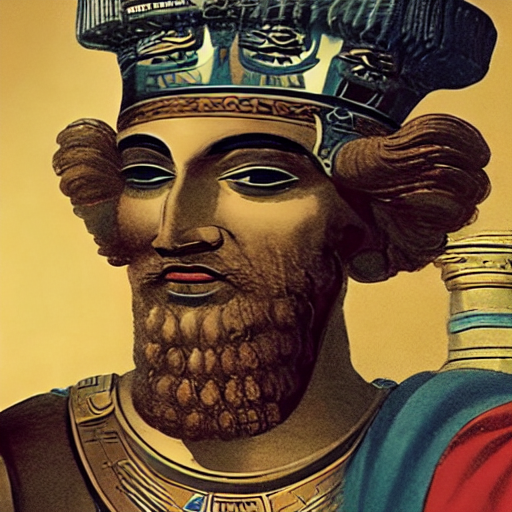

In [28]:
generate(pipe, prompt_new, seed)

We get a very different style after applying the LoRA trained weights.